# exp011: 損失関数比較分析

MSE, Huber, sample_weight, MAPE, Focal の比較分析

In [1]:
import sys
from pathlib import Path
import os

# プロジェクトルート設定
notebook_dir = Path().resolve()
exp_dir = notebook_dir.parent
project_root = exp_dir.parents[1]
sys.path.insert(0, str(project_root / "04_src"))
os.chdir(project_root)

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from evaluation.metrics import calculate_mape

plt.rcParams['figure.figsize'] = (12, 6)

outputs_dir = exp_dir / "outputs"
print(f"Project root: {project_root}")
print(f"Outputs: {outputs_dir}")

Project root: /Users/kotaro/Desktop/ML/20251122_signamte_mlit
Outputs: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp011_loss_function/outputs


## 1. データ読み込み

In [2]:
# 利用可能なディレクトリを自動検出
loss_types = ["mse", "huber", "sample_weight", "mape", "focal"]
loss_dirs = {}

for loss_type in loss_types:
    pattern = f"run_{loss_type}_*"
    matches = list(outputs_dir.glob(pattern))
    if matches:
        loss_dirs[loss_type] = sorted(matches)[-1]
        print(f"{loss_type}: {loss_dirs[loss_type].name}")
    else:
        print(f"{loss_type}: Not found")

mse: run_mse_20251128_162944
huber: run_huber_20251128_175624
sample_weight: run_sample_weight_20251128_184403
mape: run_mape_20251128_200141
focal: run_focal_20251128_203216


In [3]:
# OOF予測を読み込み
oof_predictions = {}
for name, path in loss_dirs.items():
    oof_path = path / "oof_predictions.csv"
    if oof_path.exists():
        df = pl.read_csv(oof_path)
        oof_predictions[name] = df
        print(f"{name}: {len(df)} rows")

mse: 363924 rows
huber: 363924 rows
sample_weight: 363924 rows
mape: 363924 rows
focal: 363924 rows


In [4]:
# 分析用DataFrameを作成（OOFのactualカラムを使用）
base_name = list(oof_predictions.keys())[0]
base_df = oof_predictions[base_name]

analysis_df = pl.DataFrame({
    "price": base_df["actual"].to_numpy(),
})

for name, df in oof_predictions.items():
    analysis_df = analysis_df.with_columns(
        pl.Series(name=f"pred_{name}", values=df["predicted"].to_numpy())
    )

print(f"Analysis DataFrame: {analysis_df.shape}")
analysis_df.head()

Analysis DataFrame: (363924, 6)


price,pred_mse,pred_huber,pred_sample_weight,pred_mape,pred_focal
i64,f64,f64,f64,f64,f64
13980000,1.6441e7,1.5649e7,1.6099e7,1.6887e7,1.6949e7
24480000,2.7157e7,2.1490e7,2.5551e7,2.2318e7,2.1547e7
24480000,2.2724e7,2.2976e7,2.3029e7,2.3374e7,2.2705e7
16300000,2.1289e7,2.2472e7,2.1528e7,2.1595e7,2.1844e7
18800000,1.7863e7,1.7922e7,1.7840e7,1.8223e7,1.7391e7


## 2. 全体スコア比較

In [5]:
# 各損失関数のMAPEを計算
results = []
y_true = analysis_df["price"].to_numpy()

for name in oof_predictions.keys():
    y_pred = analysis_df[f"pred_{name}"].to_numpy()
    mape = calculate_mape(y_true, y_pred)
    results.append({"損失関数": name, "MAPE (%)": mape})

results_df = pl.DataFrame(results).sort("MAPE (%)")
results_df

損失関数,MAPE (%)
str,f64
"""huber""",12.16729
"""mse""",12.188847
"""sample_weight""",12.241387
"""focal""",12.58009
"""mape""",12.828184


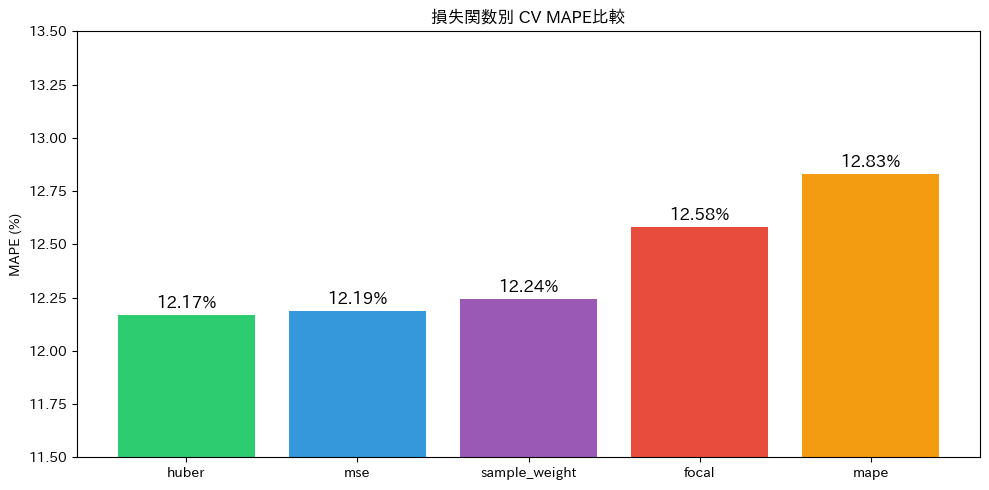

In [6]:
# 棒グラフで比較
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#2ecc71", "#3498db", "#9b59b6", "#e74c3c", "#f39c12"]
names = results_df["損失関数"].to_list()
mapes = results_df["MAPE (%)"].to_list()

bars = ax.bar(names, mapes, color=colors[:len(names)])
ax.set_ylabel("MAPE (%)")
ax.set_title("損失関数別 CV MAPE比較")
ax.set_ylim(11.5, 13.5)

for bar, val in zip(bars, mapes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f"{val:.2f}%", ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.show()

## 3. 価格帯別比較

In [7]:
# 価格帯を定義
analysis_df = analysis_df.with_columns(
    pl.when(pl.col("price") < 5_000_000).then(pl.lit("500万未満"))
    .when(pl.col("price") < 10_000_000).then(pl.lit("500-1000万"))
    .when(pl.col("price") < 30_000_000).then(pl.lit("1000-3000万"))
    .otherwise(pl.lit("3000万以上"))
    .alias("price_bin")
)

analysis_df.group_by("price_bin").len().sort("price_bin")

price_bin,len
str,u32
"""1000-3000万""",214191
"""3000万以上""",101377
"""500-1000万""",47066
"""500万未満""",1290


In [8]:
# 価格帯別にMAPEを計算
price_bins = ["500万未満", "500-1000万", "1000-3000万", "3000万以上"]
price_mape = []

for price_bin in price_bins:
    subset = analysis_df.filter(pl.col("price_bin") == price_bin)
    row = {"価格帯": price_bin, "件数": len(subset)}
    
    y_true = subset["price"].to_numpy()
    for name in oof_predictions.keys():
        y_pred = subset[f"pred_{name}"].to_numpy()
        row[name] = calculate_mape(y_true, y_pred)
    price_mape.append(row)

price_mape_df = pl.DataFrame(price_mape)
price_mape_df

価格帯,件数,mse,huber,sample_weight,mape,focal
str,i64,f64,f64,f64,f64,f64
"""500万未満""",1290,33.678698,33.189758,33.572188,36.586932,33.942873
"""500-1000万""",47066,19.607447,19.570987,19.254713,20.99024,20.174213
"""1000-3000万""",214191,11.543521,11.527809,11.636115,12.055937,11.90547
"""3000万以上""",101377,9.834638,9.813597,9.992728,10.368103,10.207902


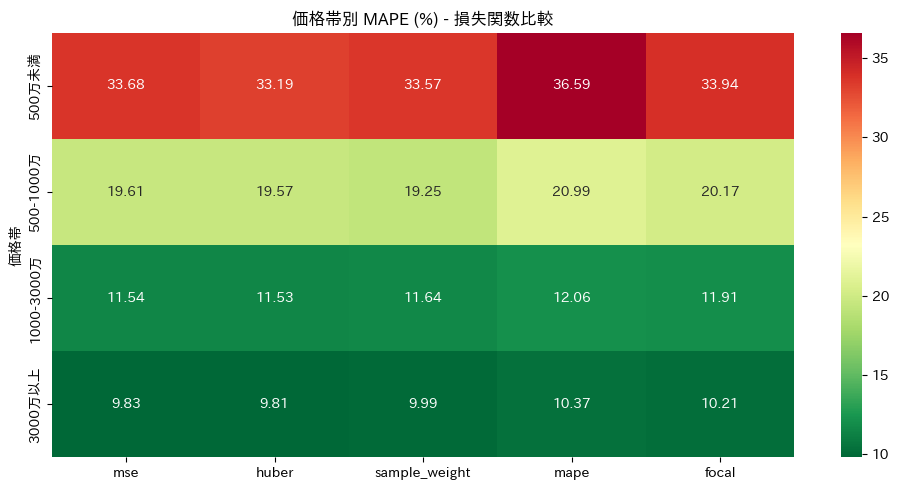

In [9]:
# ヒートマップで可視化
heatmap_data = price_mape_df.select(["価格帯"] + list(oof_predictions.keys())).to_pandas()
heatmap_data = heatmap_data.set_index("価格帯")

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="RdYlGn_r", ax=ax)
ax.set_title("価格帯別 MAPE (%) - 損失関数比較")
plt.tight_layout()
plt.show()

## 4. 予測バイアス比較

In [10]:
# 過大予測・過小予測の比率を計算
bias_data = []
for name in oof_predictions.keys():
    residuals = analysis_df[f"pred_{name}"].to_numpy() - analysis_df["price"].to_numpy()
    overestimate = (residuals > 0).mean() * 100
    underestimate = (residuals < 0).mean() * 100
    bias_data.append({
        "損失関数": name,
        "過大予測 (%)": overestimate,
        "過小予測 (%)": underestimate,
    })

bias_df = pl.DataFrame(bias_data)
bias_df

損失関数,過大予測 (%),過小予測 (%)
str,f64,f64
"""mse""",49.322111,50.677889
"""huber""",49.216595,50.783405
"""sample_weight""",49.648828,50.351172
"""mape""",49.723843,50.276157
"""focal""",48.985777,51.014223


In [11]:
# 価格帯別のバイアス
bias_by_price = []
for price_bin in price_bins:
    subset = analysis_df.filter(pl.col("price_bin") == price_bin)
    for name in oof_predictions.keys():
        residuals = subset[f"pred_{name}"].to_numpy() - subset["price"].to_numpy()
        overestimate = (residuals > 0).mean() * 100
        bias_by_price.append({
            "価格帯": price_bin,
            "損失関数": name,
            "過大予測率 (%)": overestimate,
        })

bias_by_price_df = pl.DataFrame(bias_by_price)
bias_pivot = bias_by_price_df.to_pandas().pivot(index="価格帯", columns="損失関数", values="過大予測率 (%)")
bias_pivot = bias_pivot.reindex(price_bins)
bias_pivot

損失関数,focal,huber,mape,mse,sample_weight
価格帯,,,,,
500万未満,93.178295,91.550388,92.325581,90.775194,93.488372
500-1000万,71.491098,70.921684,71.720563,71.212765,71.705690
1000-3000万,48.930627,49.277981,50.026378,49.402169,49.716842
3000万以上,38.091480,38.471251,38.330193,38.462373,38.707005


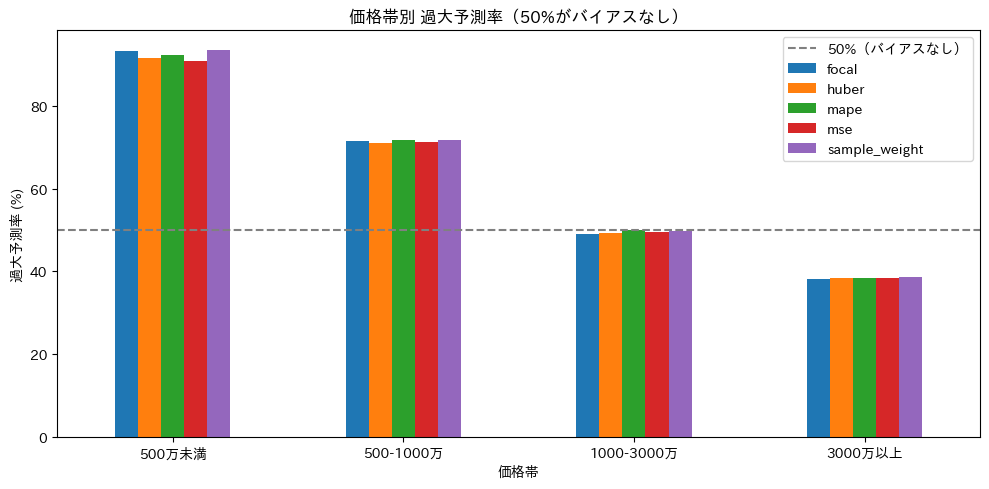

In [12]:
# 可視化
fig, ax = plt.subplots(figsize=(10, 5))
bias_pivot.plot(kind="bar", ax=ax)
ax.axhline(50, color="gray", linestyle="--", label="50%（バイアスなし）")
ax.set_ylabel("過大予測率 (%)")
ax.set_title("価格帯別 過大予測率（50%がバイアスなし）")
ax.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. 予測分布の比較

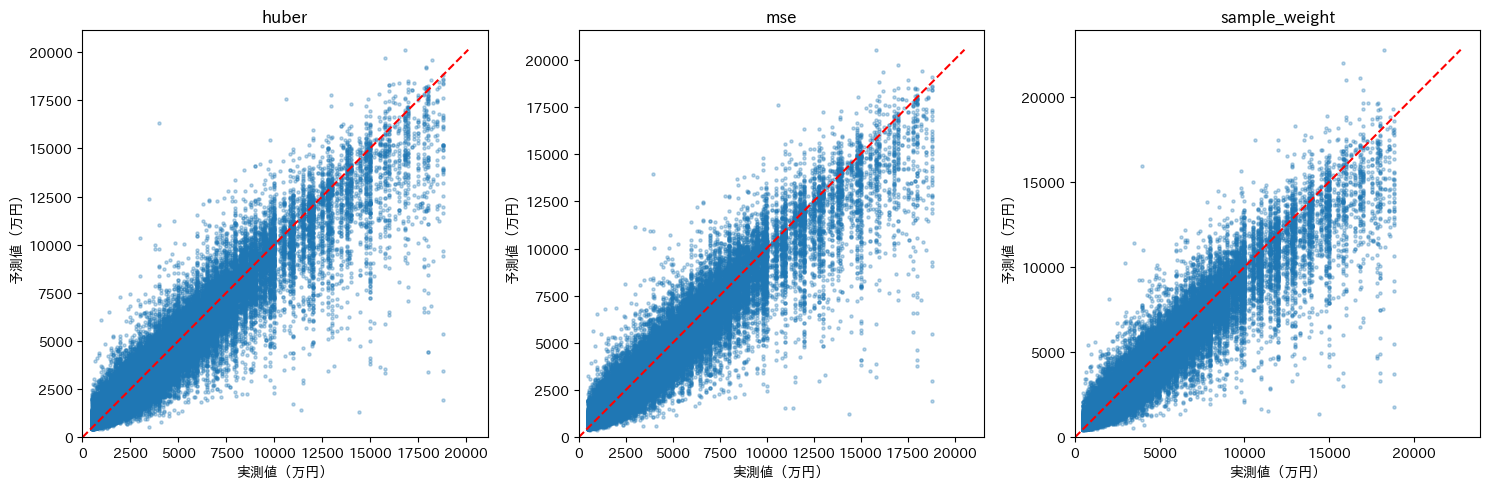

In [13]:
# 実測値 vs 予測値の散布図（上位3モデル）
loss_names = results_df["損失関数"].to_list()[:3]
n_cols = len(loss_names)

fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))
if n_cols == 1:
    axes = [axes]

y_true = analysis_df["price"].to_numpy() / 10000

for idx, name in enumerate(loss_names):
    ax = axes[idx]
    y_pred = analysis_df[f"pred_{name}"].to_numpy() / 10000
    
    ax.scatter(y_true, y_pred, alpha=0.3, s=5)
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], 'r--', label="y=x")
    
    ax.set_xlabel("実測値（万円）")
    ax.set_ylabel("予測値（万円）")
    ax.set_title(f"{name}")
    ax.set_xlim(0, max_val * 1.05)
    ax.set_ylim(0, max_val * 1.05)

plt.tight_layout()
plt.show()

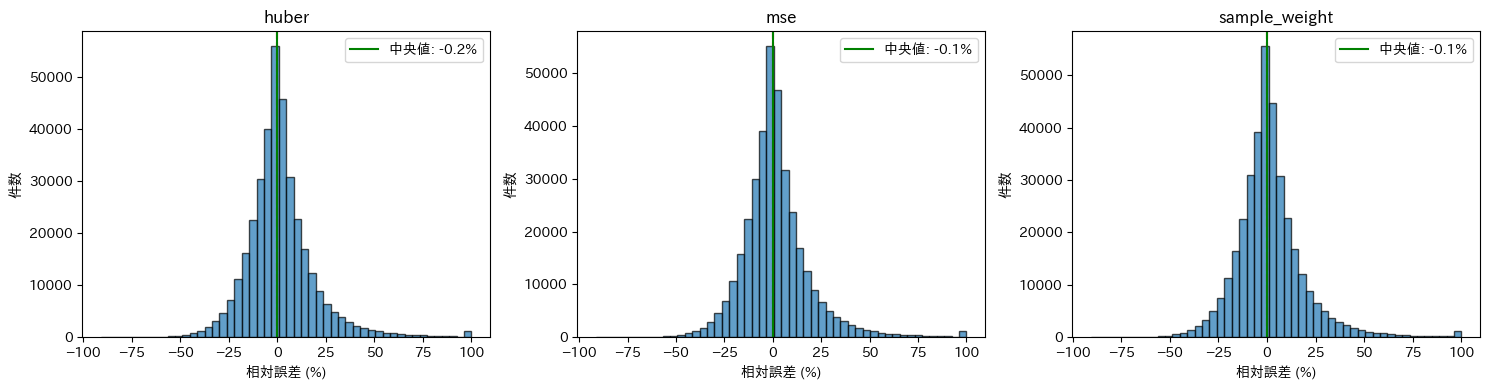

In [14]:
# 残差分布の比較
fig, axes = plt.subplots(1, len(loss_names), figsize=(5*len(loss_names), 4))
if len(loss_names) == 1:
    axes = [axes]

for idx, name in enumerate(loss_names):
    ax = axes[idx]
    pct_error = (analysis_df[f"pred_{name}"].to_numpy() - analysis_df["price"].to_numpy()) / analysis_df["price"].to_numpy() * 100
    pct_error_clipped = np.clip(pct_error, -100, 100)
    
    ax.hist(pct_error_clipped, bins=50, edgecolor="black", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--")
    ax.axvline(np.median(pct_error), color="green", linestyle="-", label=f"中央値: {np.median(pct_error):.1f}%")
    ax.set_xlabel("相対誤差 (%)")
    ax.set_ylabel("件数")
    ax.set_title(f"{name}")
    ax.legend()

plt.tight_layout()
plt.show()

## 6. アンサンブル効果

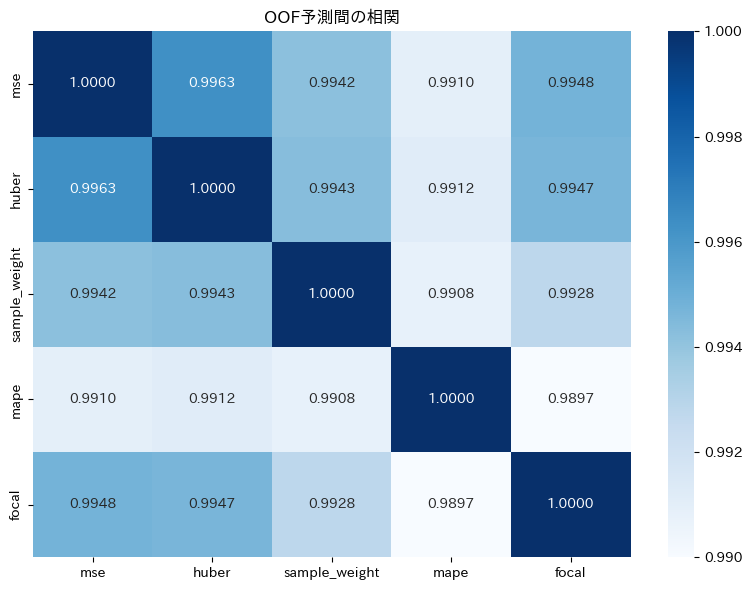

In [15]:
# OOF予測間の相関
pred_cols = [f"pred_{name}" for name in oof_predictions.keys()]
corr_data = analysis_df.select(pred_cols).to_pandas()
corr_matrix = corr_data.corr()

corr_matrix.columns = list(oof_predictions.keys())
corr_matrix.index = list(oof_predictions.keys())

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap="Blues", ax=ax, vmin=0.99, vmax=1.0)
ax.set_title("OOF予測間の相関")
plt.tight_layout()
plt.show()

In [16]:
# 単純平均アンサンブル
pred_arrays = [analysis_df[f"pred_{name}"].to_numpy() for name in oof_predictions.keys()]
ensemble_pred = np.mean(pred_arrays, axis=0)

y_true = analysis_df["price"].to_numpy()
ensemble_mape = calculate_mape(y_true, ensemble_pred)
print(f"単純平均アンサンブル MAPE: {ensemble_mape:.4f}%")

print("\n各モデルとの比較:")
for name in oof_predictions.keys():
    mape = calculate_mape(y_true, analysis_df[f"pred_{name}"].to_numpy())
    diff = mape - ensemble_mape
    print(f"  {name}: {mape:.4f}% (差: {diff:+.4f}%)")

単純平均アンサンブル MAPE: 11.9902%

各モデルとの比較:
  mse: 12.1888% (差: +0.1986%)
  huber: 12.1673% (差: +0.1771%)
  sample_weight: 12.2414% (差: +0.2512%)
  mape: 12.8282% (差: +0.8380%)
  focal: 12.5801% (差: +0.5899%)


In [17]:
# 2モデルの組み合わせで最適重みを探索
if len(oof_predictions) >= 2:
    names = list(oof_predictions.keys())
    
    print("2モデルの重み付き平均（最適重み探索）:")
    best_overall = float("inf")
    best_combo = ""
    
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            name1, name2 = names[i], names[j]
            pred1 = analysis_df[f"pred_{name1}"].to_numpy()
            pred2 = analysis_df[f"pred_{name2}"].to_numpy()
            
            best_mape = float("inf")
            best_w = 0.5
            
            for w in np.arange(0, 1.01, 0.05):
                pred = w * pred1 + (1-w) * pred2
                mape = calculate_mape(y_true, pred)
                if mape < best_mape:
                    best_mape = mape
                    best_w = w
            
            print(f"  {name1} ({best_w:.2f}) + {name2} ({1-best_w:.2f}): {best_mape:.4f}%")
            
            if best_mape < best_overall:
                best_overall = best_mape
                best_combo = f"{name1} ({best_w:.2f}) + {name2} ({1-best_w:.2f})"
    
    print(f"\n最良の組み合わせ: {best_combo} = {best_overall:.4f}%")

2モデルの重み付き平均（最適重み探索）:
  mse (0.50) + huber (0.50): 12.0211%
  mse (0.55) + sample_weight (0.45): 12.0023%
  mse (0.80) + mape (0.20): 12.1342%


  mse (0.70) + focal (0.30): 12.1140%


  huber (0.55) + sample_weight (0.45): 11.9907%
  huber (0.80) + mape (0.20): 12.1171%
  huber (0.75) + focal (0.25): 12.0945%
  sample_weight (0.75) + mape (0.25): 12.1604%


  sample_weight (0.65) + focal (0.35): 12.1054%


  mape (0.40) + focal (0.60): 12.3497%

最良の組み合わせ: huber (0.55) + sample_weight (0.45) = 11.9907%


## 7. まとめ

In [18]:
# 結果サマリー
print("=" * 60)
print("損失関数比較 結果サマリー")
print("=" * 60)

print("\n【全体MAPE】")
print(results_df)

print("\n【価格帯別MAPE】")
print(price_mape_df)

print("\n【過大予測率】")
print(bias_df)

print("\n【アンサンブル】")
print(f"単純平均: {ensemble_mape:.4f}%")

損失関数比較 結果サマリー

【全体MAPE】
shape: (5, 2)
┌───────────────┬───────────┐
│ 損失関数      ┆ MAPE (%)  │
│ ---           ┆ ---       │
│ str           ┆ f64       │
╞═══════════════╪═══════════╡
│ huber         ┆ 12.16729  │
│ mse           ┆ 12.188847 │
│ sample_weight ┆ 12.241387 │
│ focal         ┆ 12.58009  │
│ mape          ┆ 12.828184 │
└───────────────┴───────────┘

【価格帯別MAPE】
shape: (4, 7)
┌─────────────┬────────┬───────────┬───────────┬───────────────┬───────────┬───────────┐
│ 価格帯      ┆ 件数   ┆ mse       ┆ huber     ┆ sample_weight ┆ mape      ┆ focal     │
│ ---         ┆ ---    ┆ ---       ┆ ---       ┆ ---           ┆ ---       ┆ ---       │
│ str         ┆ i64    ┆ f64       ┆ f64       ┆ f64           ┆ f64       ┆ f64       │
╞═════════════╪════════╪═══════════╪═══════════╪═══════════════╪═══════════╪═══════════╡
│ 500万未満   ┆ 1290   ┆ 33.678698 ┆ 33.189758 ┆ 33.572188     ┆ 36.586932 ┆ 33.942873 │
│ 500-1000万  ┆ 47066  ┆ 19.607447 ┆ 19.570987 ┆ 19.254713     ┆ 20.99024  ┆ 20.17421

In [19]:
# 考察
print("""
## 考察

### 全体傾向
| 損失関数 | CV MAPE | 備考 |
|----------|---------|------|
| **Huber** | **12.17%** | **最良** |
| MSE | 12.19% | ベースライン |
| sample_weight | 12.24% | inverse重み付け |
| Focal (γ=2.0) | 12.58% | 難サンプル重視 |
| MAPE | 12.83% | MAPE直接最適化 |

### 結論
1. **Huberが最良**: 12.17%（MSEより0.02%改善）
2. **カスタム目的関数は効果薄**: MAPE直接最適化やFocalは全体MAPEを悪化
3. **log1p変換の効果**: 既に低価格帯の相対的重要度が高まっているため、
   追加の重み付け効果は限定的
4. **予測間相関が高い**: 0.99以上のため単純平均の改善効果は限定的
""")


## 考察

### 全体傾向
| 損失関数 | CV MAPE | 備考 |
|----------|---------|------|
| **Huber** | **12.17%** | **最良** |
| MSE | 12.19% | ベースライン |
| sample_weight | 12.24% | inverse重み付け |
| Focal (γ=2.0) | 12.58% | 難サンプル重視 |
| MAPE | 12.83% | MAPE直接最適化 |

### 結論
1. **Huberが最良**: 12.17%（MSEより0.02%改善）
2. **カスタム目的関数は効果薄**: MAPE直接最適化やFocalは全体MAPEを悪化
3. **log1p変換の効果**: 既に低価格帯の相対的重要度が高まっているため、
   追加の重み付け効果は限定的
4. **予測間相関が高い**: 0.99以上のため単純平均の改善効果は限定的

